# loss 먼저 넣고 backward+step vs backward+step후 loss의 차이점을 찾아보라.

아래 경로에 해당하는 파일을 ***복제*** 한 것임.
- ***Internship/ResNet_FER/[11.11][tensorboard, 35에폭, valid acc 43%] ResNet.ipynb***
---
위 파일(=현재 파일)에서는 backward+step 후에 loss에 접근하고 있다.   
추측하건데, loss에 접근이 안되거나(=에러), loss가 이상하게 나올 것이다.   
그 이유는, backward를 하는 순간, 추적하던 기울기가 없어지기 때문.[링크](https://jh-bk.tistory.com/13https://jh-bk.tistory.com/13)   
---



따라서,
### loss에 접근하는 것을 backward 앞으로 내보낸 뒤, backward를 하는 것 vs backward후 loss 접근
을 tensorboard로 시각화하여 보고자 한다.


---
## 11/15  13시33분 + tensorboard writer부분 loss계산하는거 step+batch for문 안에 있느냐, 아니면 epoch for문 안에 있느냐.를 점검하기위해, epoch for문안에있는 wirter를 step+batch for문안으로 넣어서 학습시켜보겠다.


---


# ResNet + tensorboard + torchinfo + Epoch당 걸리는 시간


In [1]:
import torch.nn as nn
import torch.optim as optim
from resnet import ResNet18, ResNet34, ResNet50, ResNet101, ResNet152
import os
import torchvision.models as models
from skimage import io, transform
from torch.utils.tensorboard import SummaryWriter

import datetime

import torch.backends.cudnn as cudnn
import torch
import re
import PIL
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as tr
from matplotlib import pyplot as plt

''' random seed fixed'''
import random

path = "/home/sldev1/Project/hyeongeun_test/data/FER"
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

In [2]:
#Simple Learning Rate Scheduler
def lr_scheduler(optimizer, epoch):
    lr = learning_rate
    if epoch == 50:
        lr /= 2
    if epoch == 100:
        lr /= 2
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Xavier
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [3]:
from torch.utils.data import Dataset
import glob


def img_load(img_path):

    jpg = glob.glob(img_path+'*.jpg')
    sort_jpg = sorted(jpg, key=lambda s: int(re.findall(r'\d+', s)[1]))
    #print("img_load def is play")
    return sort_jpg


def label_load(label_path):
    #enumerate #파이썬내장함수.. 강민규사원님은 이걸로 쓰셨는데 느리더래
    label = glob.glob(label_path+'*exp.npy')
    sort_label = sorted(label,key=lambda s: int(re.findall(r'\d+', s)[1]))
    #print("label_load def is play")
    return sort_label
    
    
    
class MyFERDataset(Dataset):
    
    def __init__(self, img_path_base, label_path_base, train=None, transform=None):
        super(MyFERDataset, self).__init__()
        
        if train == True:
            self.img_path = img_path_base+'/train_set/images/'
            self.label_path = label_path_base+'/train_set/annotations/'
        else:
            self.img_path = img_path_base+'/val_set/images/'
            self.label_path = label_path_base+'/val_set/annotations/'

        self.img = img_load(self.img_path)
        self.label = label_load(self.label_path)
        self.transform = transform
        
    
    def __getitem__(self, idx):
        img_read = io.imread(self.img[idx]) 
        label_read = np.load(self.label[idx])
        label_read = label_read.astype(np.int64)
        label_tr = torch.from_numpy(label_read)
        
        
        if self.transform:
            img_tr = self.transform(img_read)
        
        
        return img_tr, label_tr
    

    def __len__(self):
        return len(self.label)
    
    if __name__ == "__main__":
        print('hi, i\'m main')

hi, i'm main


In [4]:
transform_train = tr.Compose([tr.ToTensor(),
                              tr.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
transform_test = tr.Compose([tr.ToTensor()])


train_dataset = MyFERDataset(img_path_base = path,
                              label_path_base = path,
                              train=True,
                              transform=transform_train)
test_dataset = MyFERDataset(img_path_base = path,
                              label_path_base = path,
                              train=False,
                              transform=transform_test)

In [5]:
test_dataset[0]

(tensor([[[0.0588, 0.0431, 0.0431,  ..., 0.2078, 0.2196, 0.2588],
          [0.0588, 0.0471, 0.0471,  ..., 0.2118, 0.2353, 0.2824],
          [0.0588, 0.0510, 0.0588,  ..., 0.2235, 0.2627, 0.3176],
          ...,
          [0.7098, 0.7137, 0.7216,  ..., 0.8118, 0.8196, 0.8275],
          [0.7176, 0.7216, 0.7294,  ..., 0.8078, 0.8157, 0.8235],
          [0.7255, 0.7294, 0.7373,  ..., 0.8078, 0.8157, 0.8196]],
 
         [[0.0549, 0.0392, 0.0392,  ..., 0.1686, 0.1804, 0.2196],
          [0.0549, 0.0431, 0.0431,  ..., 0.1725, 0.1961, 0.2431],
          [0.0549, 0.0471, 0.0549,  ..., 0.1725, 0.2118, 0.2667],
          ...,
          [0.6667, 0.6706, 0.6784,  ..., 0.8314, 0.8392, 0.8471],
          [0.6745, 0.6784, 0.6863,  ..., 0.8275, 0.8353, 0.8431],
          [0.6824, 0.6863, 0.6941,  ..., 0.8275, 0.8353, 0.8392]],
 
         [[0.0392, 0.0235, 0.0235,  ..., 0.1333, 0.1451, 0.1843],
          [0.0392, 0.0275, 0.0275,  ..., 0.1373, 0.1608, 0.2078],
          [0.0392, 0.0314, 0.0392,  ...,

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [7]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

In [8]:
labels.size()
print(images.size())

torch.Size([32, 3, 224, 224])


In [9]:
print(labels)

tensor([0, 0, 4, 0, 2, 5, 6, 0, 7, 7, 6, 1, 4, 2, 7, 4, 2, 4, 2, 2, 7, 3, 0, 7,
        1, 3, 2, 5, 7, 2, 7, 3])


In [10]:
device = 'cuda:1'
model = ResNet50()
# ResNet18, ResNet34, ResNet50, ResNet101, ResNet152 중에 택일하여 사용

In [11]:
model.apply(init_weights)
model = model.to(device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


In [12]:
learning_rate = 0.001
num_epoch = 200
model_name = 'ResNet_FER_1117_train_loss2.pth'

loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_loss = 0
valid_loss = 0
correct = 0
total_cnt = 0
best_acc = 0

In [ ]:
import time
start = time.time() #시작 시간 저장
# Train
writer = SummaryWriter("./runs/backwardtest+step_batch_for문 안으로 writer+train_loss수정본.11.17")
for epoch in range(num_epoch):
    
    if epoch == 0:
        start = time.time() #시작 시간 저장
    if epoch == 1:
        epoch_time_for_1 = time.time()-start
        timer = epoch_time_for_1 * num_epoch
        print("학습에 총 걸리는 시간 :", timer/3600, "시간, 그리고 현재 측정완료시각 : ", datetime.datetime.now())  
    
    

    print(f"====== { epoch+1} epoch of { num_epoch } ======")
    model.train()
    lr_scheduler(optimizer, epoch)
    train_loss = 0
    valid_loss = 0
    correct = 0
    total_cnt = 0
    
    
    
    # Train Phase
    for step, batch in enumerate(train_loader):
        #  input and target
        batch[0], batch[1] = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        
        logits = model(batch[0]) #ResNet50(batch[0])
        loss = loss_fn(logits, batch[1])
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item()
        #_, predict = logits.max(1)
        _, predict = torch.max(logits, dim=1)
        
        total_cnt += batch[1].size(0)
        correct +=  predict.eq(batch[1]).sum().item()
        
        if step % 1000 == 0 and step != 0:
            print(f"\n====== { step } Step of { len(train_loader) } ======")
            print(f"Train Acc : { correct / total_cnt }")
            print(f"Train Loss : { loss.item() / batch[1].size(0) }")

            
        train_acc_visual = (correct / total_cnt) * 100
        # train_loss_visual = loss.item() / batch[1].size(0) <====이거 틀렸다 아래가 맞다
        train_loss_visual = train_loss / batch[1].size(0)
        writer.add_scalar('acc/train', train_acc_visual, epoch)
        writer.add_scalar('loss/train', train_loss_visual, epoch)            
            

    correct = 0
    total_cnt = 0
    
# Test Phase
    with torch.no_grad():
        model.eval()
        for step, batch in enumerate(test_loader):
            # input and target
            batch[0], batch[1] = batch[0].to(device), batch[1].to(device)
            total_cnt += batch[1].size(0)
            logits = model(batch[0])
            valid_loss += loss_fn(logits, batch[1])
            _, predict = logits.max(1)
            correct += predict.eq(batch[1]).sum().item()
        valid_acc = correct / total_cnt
        print(f"\nValid Acc : { valid_acc }")    
        print(f"Valid Loss : { valid_loss / total_cnt }")
        
        valid_acc_visual = valid_acc * 100
        valid_loss_visual = valid_loss / total_cnt
        writer.add_scalar('acc/valid', valid_acc_visual, epoch)
        writer.add_scalar('loss/valid', valid_loss_visual, epoch)
        
        

        if(valid_acc > best_acc):
            best_acc = valid_acc
            # torch.save(model, model_name)
            # print("Model Saved!")
            torch.save(model.state_dict(), model_name)
            print('Model Saved!')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

====== 1 epoch of 200 ======


In [14]:
model.load_state_dict(torch.load('./ResNet_FER_1115_1648.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affi

In [15]:
from torchinfo import summary
summary(model, (1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,472
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─MaxPool2d: 1-3                         [1, 64, 56, 56]           --
├─Sequential: 1-4                        [1, 256, 56, 56]          --
│    └─BottleNeck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─Conv2d: 3-3                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-4             [1, 64, 56, 56]           128
│    │    └─Conv2d: 3-5                  [1, 256, 56, 56]          16,384
│    │    └─BatchNorm2d: 3-6             [1, 256, 56, 56]          512
│    │    └─Sequential: 3-7              [1, 256, 56, 56]          

In [16]:
label_tags = {
    0 : 'Neutral',
    1 : 'Happiness', #기쁨
    2 : 'Sadness', #슬픔
    3 : 'Suprise', #놀람
    4 : 'Fear', #
    5 : 'Disgust', #역겨움
    6 : 'Anger', #분노
    7 : 'Content'
}

- 정보 :
    1. batch[0] : 이미지
    2. batch[1] : 라벨

In [17]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [34]:
for step, batch in enumerate(test_loader):
    batch[0], batch[1] = batch[0].to(device), batch[1].to(device)

    logits = model(batch[0])
    #print(batch[0], "\n****************\n", batch[1])
    print("\n******logits*******\n",logits)
    print("\n\n\n******logits_max*******\n",logits.max(1))
    
    _, predict = torch.max(logits, dim=1)
    # _, predict = logits.max()
    print("\n\n***********_____***********\n", _, "\n\n**********predict************\n", predict)
    
    # correct += predict.eq(batch[1]).sum().item()
    # print(correct)


    
    #valid_loss += loss_fn(logits, batch[1])
    #_, predict = logits.max(1)
    #correct += predict.eq(batch[1]).sum().item()
    #print(_,"\n\n\n", predict)


******logits*******
 tensor([[ 2.1195,  2.7134,  2.5982, -2.9567, -0.5159, -0.1822,  1.0926, -0.5362,
         -0.4513,  0.6408],
        [ 2.7935,  3.1004,  2.8023, -3.0783, -0.2720, -0.3425,  2.2156, -0.8654,
         -0.2742,  1.2150],
        [ 2.7593,  3.4954,  2.7906, -2.9082, -0.6154, -0.2392,  1.6464, -0.7873,
          0.1432,  1.1898],
        [ 1.8798,  3.4004,  2.7182, -2.5275, -0.2999,  0.0271,  1.9154, -0.8489,
         -0.0723,  0.5180]], device='cuda:0', grad_fn=<AddmmBackward0>)



******logits_max*******
 torch.return_types.max(
values=tensor([2.7134, 3.1004, 3.4954, 3.4004], device='cuda:0',
       grad_fn=<MaxBackward0>),
indices=tensor([1, 1, 1, 1], device='cuda:0'))


***********_____***********
 tensor([2.7134, 3.1004, 3.4954, 3.4004], device='cuda:0',
       grad_fn=<MaxBackward0>) 

**********predict************
 tensor([1, 1, 1, 1], device='cuda:0')

******logits*******
 tensor([[ 2.8309,  4.2414,  2.9858, -3.4669, -0.0742, -0.1062,  3.0931, -1.6901,
        

KeyboardInterrupt: 

In [135]:
data_idx = np.random.randint(len(test_dataset))
print(f"data_idx : {data_idx}\n\n")

input_img = test_dataset[0][0].unsqueeze(dim=0).to(device)
# input_img = test_dataset[data_idx][0].unsqueeze(dim=0).to(device)
# print(f"iput_img : {input_img}")
output = model(input_img)
output



x = torch.max(output, 1)
x

# torch.return_types.max(
# values=tensor([3.1417], device='cuda:0', grad_fn=<MaxBackward0>),
# indices=tensor([1], device='cuda:0'))

_, argmax = torch.max(output, 1)
print(f"_ : {_}, \nargmax : {argmax}")
# type(argmax.size())

pred = label_tags[argmax.item()]
pred
#label = label_tags[test_dataset[data_idx][1].item()]
#label


#pred = label_tags[argmax.item()]
        #test_dataset = test_dataset.numpy()
#label = label_tags[test_dataset[data_idx][1]]

data_idx : 2431


_ : tensor([3.1417], device='cuda:0', grad_fn=<MaxBackward0>), 
argmax : tensor([1], device='cuda:0')


'Happiness'

In [40]:
len(test_dataset)

3999

In [74]:
x = label_load("/home/sldev1/Project/hyeongeun_test/data/FER/val_set/annotations/")[0].split('/')
x[-1]

'0_exp.npy'

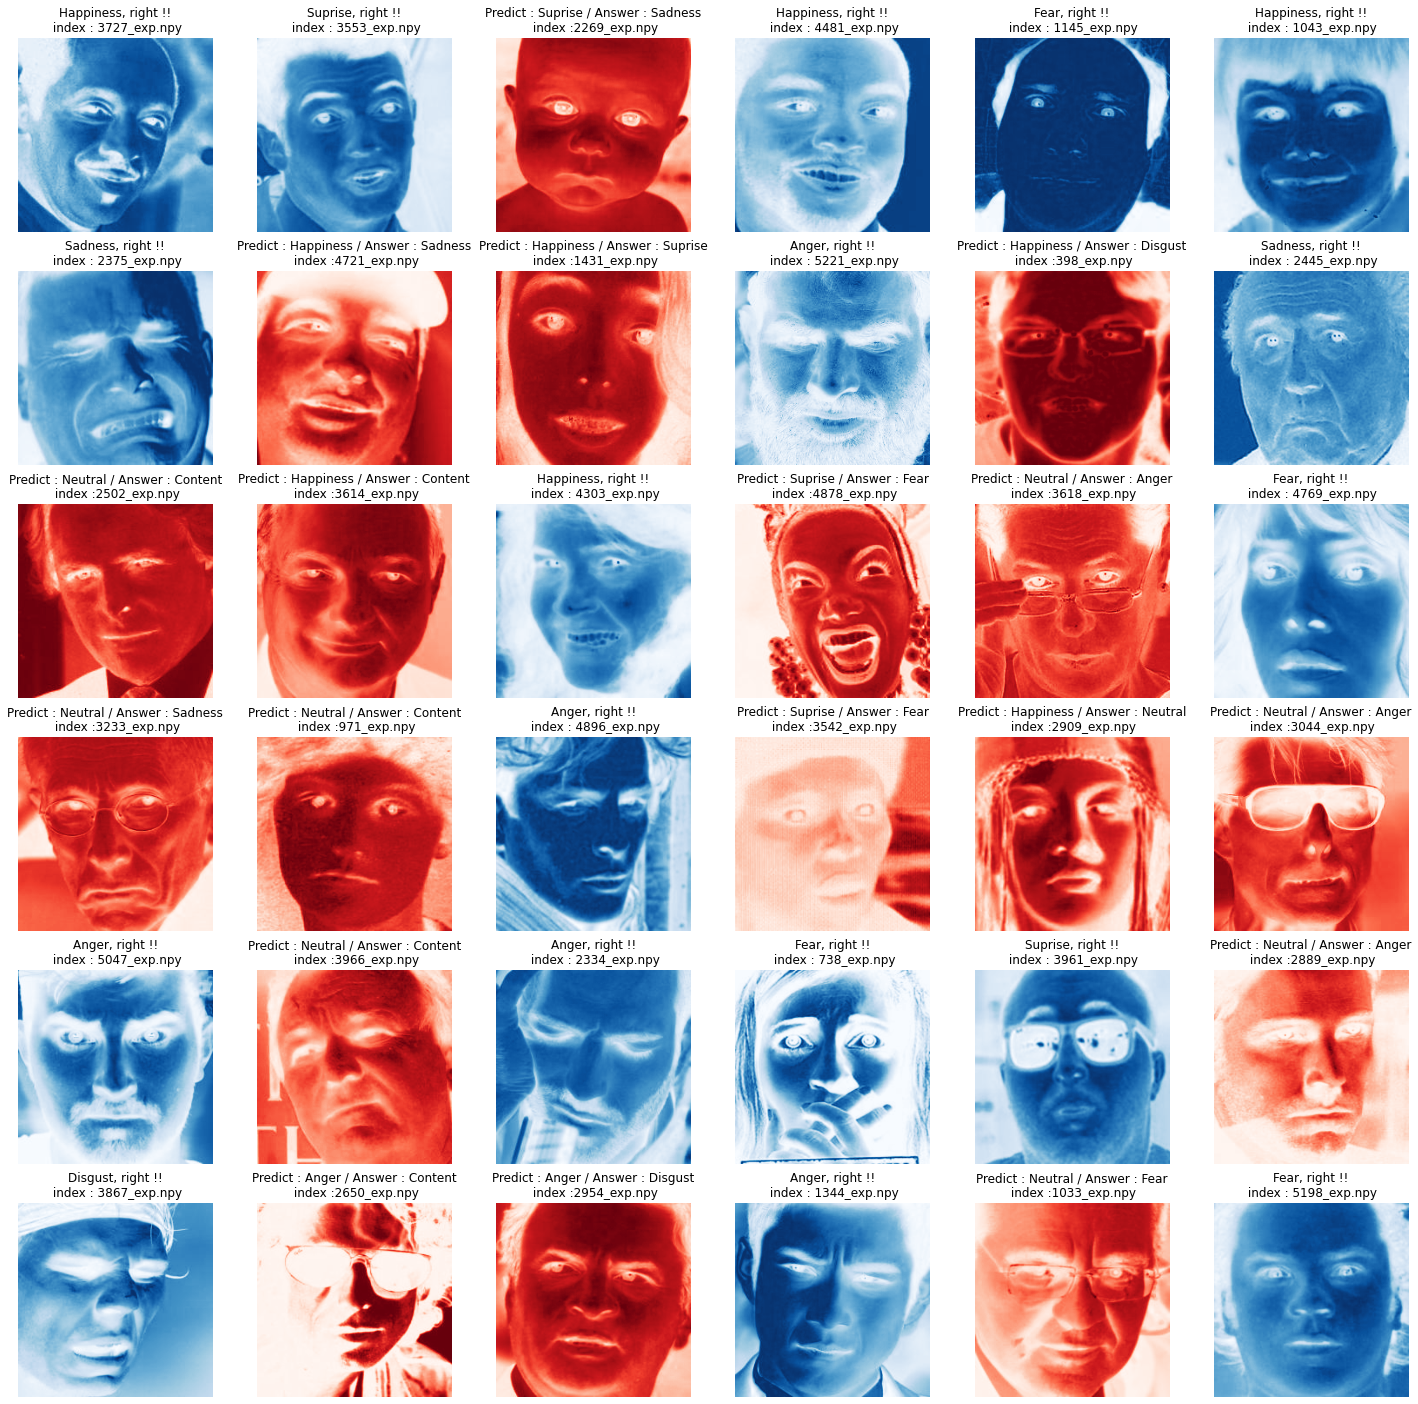

In [18]:
import cv2

columns = 6
rows = 6
fig = plt.figure(figsize=(25,25))

device = "cuda"

# inference
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(4000)
    input_img = test_dataset[data_idx][0].unsqueeze(dim=0).to(device) 
    

    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = label_tags[argmax.item()]
    #test_dataset = test_dataset.numpy()
    label = label_tags[test_dataset[data_idx][1].item()]
    
    
    x = label_load("/home/sldev1/Project/hyeongeun_test/data/FER/val_set/annotations/")[data_idx].split('/')
    x = x[-1]
    
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + ', right !!\n index : ' + str(x))
        cmap = 'Blues'
    else:
        plt.title('Predict : ' + pred + ' / Answer : ' +  label + '\n index :' + str(x))
        cmap = 'Reds'
    plot_img = test_dataset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    #plt.imshow(plot_img)
    plt.axis('off')
    
plt.show() 

In [1]:
num = 4420
x = cv2.imread(f"/home/sldev1/Project/hyeongeun_test/data/FER/val_set/images/{num}.jpg", cv2.IMREAD_COLOR)
y = int(np.load(f"/home/sldev1/Project/hyeongeun_test/data/FER/val_set/annotations/{num}_exp.npy"))

label_tags = {
    0 : 'Neutral',
    1 : 'Happiness', #기쁨
    2 : 'Sadness', #슬픔
    3 : 'Suprise', #놀람
    4 : 'Fear', #
    5 : 'Disgust', #역겨움
    6 : 'Anger', #분노
    7 : 'Content' #만족
}

plt.title(label_tags[y])
plt.imshow(x)



NameError: name 'cv2' is not defined

In [81]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [22]:
!tensorboard --logdir="./runs/backwardtest+step_batch_for문 안으로 writer.11.15.1648"

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# 테스트 데이터에 대한 모델 테스트
https://learn.microsoft.com/ko-kr/windows/ai/windows-ml/tutorials/pytorch-train-model #보류